In [148]:
%reset -f

In [158]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt

In [182]:
# load x, y

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# flatten x
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

In [183]:
y_train[y_train>5] = 255
y_train[y_train!=255] = 0
y_train[y_train==255] = 1

In [184]:
y_test[y_test>5] = 255
y_test[y_test!=255] = 0
y_test[y_test==255] = 1

In [185]:
# binary classification problem. Class 1 if digit is > 5 or else it is Class 0

def fLDA_train(X, y):
    mean1 = (np.mean(X[y==1], axis=0)).reshape(-1,1)
    mean0 = (np.mean(X[y==0], axis=0)).reshape(-1,1)

    cov1 = np.cov(X[y==1].T)
    cov0 = np.cov(X[y==0].T)

    Sw = cov1 + cov0

    w = np.linalg.inv(Sw+1*np.eye(Sw.shape[0])).dot(mean1 - mean0)


    return mean1, mean0, w

In [186]:
def fLDA_test(X, y, w):
    y_pred = np.sign(X.dot(w))
    y_pred[y_pred==-1] = 0
    y_pred = y_pred.reshape(-1,1)
    y = y.reshape(-1,1)
    acc = len(y[y==y_pred])/len(y)
    return acc


In [187]:
mean1, mean0, w = fLDA_train(x_train, y_train)
print(fLDA_test(x_test, y_test, w))

0.6907


In [188]:
w.shape

(784, 1)

IndexError: boolean index did not match indexed array along dimension 1; dimension is 784 but corresponding boolean dimension is 1

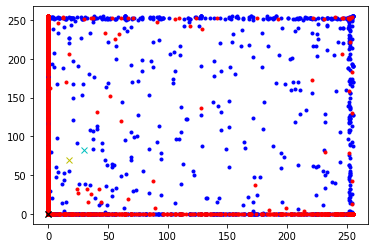

In [196]:
import matplotlib.cm as cm

plt.figure()
plt.plot(x_test[y_test==0][:,498], x_test[y_test==0][:,244], 'b.')
plt.plot(x_test[y_test==1][:,498], x_test[y_test==1][:,244], 'r.')

plt.plot([-w[498], w[498]], [-w[244], w[244]], 'kx') 
plt.plot(mean0[498], mean0[244], 'cx')
plt.plot(mean1[498], mean1[244], 'yx')

y_pred = np.sign(x_test.dot(w))
y_pred[y_pred==-1] = 0
y_pred = y_pred.reshape(-1,1)
y = y_test.reshape(-1,1)

classes = np.unique(y)
colors = cm.rainbow(np.linspace(0, 1, len(classes)))

plotlabels = {classes[c] : colors[c] for c in range(len(classes))}

for i in range(len(classes)):
    plt.scatter()
plt.show()